In [2]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

import logistic_regression_functions as lrf
import GradientDescent as GD
GradientDescent = GD.GradientDescent

%load_ext autoreload
%autoreload 2

# Always make it pretty.
plt.style.use('ggplot')

%matplotlib inline

Gradient Descent Solutions
==========================

## Data Generation and EDA

**Q:** Generate a dataset using sklearn's make_classification module.

In [3]:
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    random_state=0)

**Q:** We use two features so that we can visualize our data. Make a scatterplot with the first feature on the x axis and the second on the y axis. Differentiate the positive results from the negative results somehow (different colors or different symbols).

We choose to differentiate the two classes with different colored data points.  It is important, when choosing colors, to be aware of colorblind consumers.  Red and blue are good choices.

In [4]:
def plot_classification_data(X, y, ax):
    """Add a scatter plot of data to an axis.
    
    Parameters
    ----------
    X: ndarray, shape (n_samples, 2)
    y: ndarray, shape (n_samples, )
    ax: matplotlib axis object
    """
    colors = np.array(["red", "blue"])[y]
    ax.scatter(X[:, 0], X[:, 1], color=colors)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

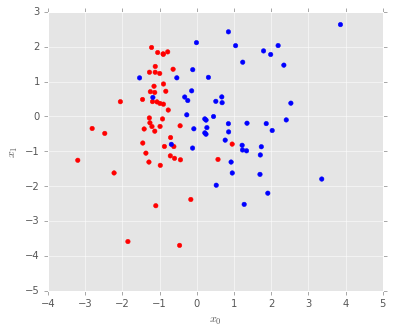

In [7]:
fig, ax = plt.subplots(1, figsize=(6, 5))

plot_classification_data(X, y, ax)

**Q:** Just by eye-balling, make an estimate for a good coefficient for this equation: `y = mx` of the decision boundary. We are using this form since our first implementation will not find an intercept. But also make an estimate for good coefficients for this equation: `y = mx+b`

It looks like a decent decision boundary for this data (given that it is of the form `y = mx`) would pass through the data points $(0, 0)$ and $(-1, 1.5)$.  This gives the slope `m` from the following simple calculation:

$$ m = \frac{1.5 - 0}{-1 - 0} = \frac{1.5}{-1} = -1.5 $$

Let's superimpose this line on the above plot above.

In [5]:
def compute_scatterplot_bounds(X):
    """Compute the axis bounds for a scatterplot from a two column matrix of data.
    
    Parameters
    ----------
    X: ndarray, shape (n_samples, 2)
    """
    x0_bounds = (X[:, 0].min(), X[:, 0].max())
    x1_bounds = (X[:, 1].min(), X[:, 1].max())
    return x0_bounds, x1_bounds

def set_scatterplot_bounds(x0_bounds, x1_bounds, ax):
    """Set the axis bounds on a matplotlib axis.
    
    Parameters
    ----------
    x0_bounds: tuple with two elements.  The bounds on the first axis.
    x1_bounds: tuple with two elements.  The bounds on the second axis.
    ax: matplotlib axis object
    """
    ax.set_xlim(x0_bounds)
    ax.set_ylim(x1_bounds)

In [6]:
def plot_eyeballed_line_no_intercept(X, ax):
    """Add the zero intercept line we eyeballed above to the scatterplot."""
    x0_bounds, x1_bounds = compute_scatterplot_bounds(X)
    t = np.linspace(x0_bounds[0], x0_bounds[1], num=3)
    ax.plot(t, -1.5*t, linestyle='--', label="Eyeballed Line")
    set_scatterplot_bounds(x0_bounds, x1_bounds, ax)

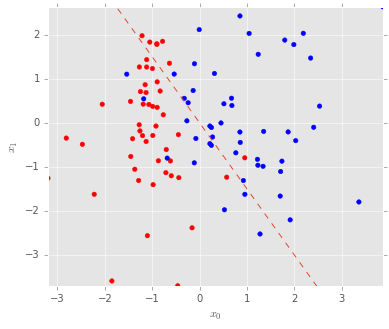

In [7]:
fig, ax = plt.subplots(1, figsize=(6, 5))

plot_classification_data(X, y, ax)
plot_eyeballed_line_no_intercept(X, ax)

That looks alright for an eyballed line.

It's a bit harder to eyeball a line with an intercept, so I grabbed a straightedge and slid it around my monitor (be careful not to scratch your beautiful retina display).  I came up with a line that went through the points $(1, -4)$ and $(-1, 2)$. 

So:

$$ m = \frac{2 - (-4)}{-1 - 1} = -\frac{6}{2} = -3 $$

Solving for the intercept:

$$ 2 = (-3) \times (-1) + b \Rightarrow b = 2 - 3 = -1 $$

So alltogether out eyeballed line is:

$$ y = -3 x -1 $$

In [8]:
def plot_eyeballed_line(X, ax):
    """Add the line we eyeballed above to the scatterplot."""
    x0_bounds, x1_bounds = compute_scatterplot_bounds(X)
    t = np.linspace(x0_bounds[0], x0_bounds[1], num=3)
    ax.plot(t, -3*t - 1, linestyle='--', label="Eyeballed Line")
    set_scatterplot_bounds(x0_bounds, x1_bounds, ax)

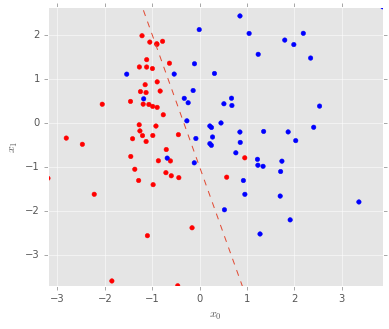

In [9]:
fig, ax = plt.subplots(1, figsize=(6, 5))

plot_classification_data(X, y, ax)
plot_eyeballed_line(X, ax)

This looks pretty ok for an eyeball estimate, but we can surely do better.  Thankfully, we have **data science**!

## Implementing the Cost Function

The trickiest implementation is the `gradient` so we will focus on that (the implementation of cost follows a similar, but simpler, path).

The gradient was expressed in the assignment in terms of indices and summations:

$$ \frac{\partial J}{\partial \beta_j} = \sum_i^n (h(x_i) - y_i) x_{ij} $$

All of the partial derivatives, when taken together, creates the gradient *vector*.  We can then express this whole thing as a matrix equation

$$ \nabla J = X^t (p - y) $$

where $p$ is the *vector* of predicted probabilities.  Note that we had to introduce the transpose of $X$, because the sum in the formula is over the *inner* index of $x_{ij}$

Now we can take the sample data from the exercise, 


|                   | feature 1 | feature 2 |   y |
| ----------------- | --------- | --------- | --- |
| **x<sub>1</sub>** |         0 |         1 |   1 |
| **x<sub>2</sub>** |         2 |         2 |   0 |
| **x<sub>3</sub>** |         3 |         0 |   0 |


and try out our implementations:

In [10]:
X_sample = np.array([[0, 1], [2, 2], [3, 0]])
y_sample = np.array([1, 0, 0])
coeffs = np.array([1, -0.5])

In [11]:
p = lrf.predict_proba(X_sample, coeffs)
y_hat = lrf.predict(X_sample, coeffs)
cost = lrf.cost(X_sample, y_sample, coeffs)
grad = lrf.gradient(X_sample, y_sample, coeffs)

In [12]:
print("The predicted probability vector is {}".format(str(p)))
print("The predicted class vector is {}".format(str(y_hat)))
print("The cost function at these coefficients is {}".format(str(cost)))
print("The gradient of the cost is {}".format(str(grad)))

The predicted probability vector is [ 0.37754067  0.73105858  0.95257413]
The predicted class vector is [False  True  True]
The cost function at these coefficients is 5.33592602327
The gradient of the cost is [ 4.31983954  0.83965783]


## Implement Gradient Descent

There is not too much to comment on here, one of the best features of gradient descent is how easy it is to implement.

As we will be layering more features on the basic implementation as we progress through the assignemnt, here is the code for our first stripped down implementation.

```
def fit(self, X, y):
    for i in xrange(self.num_iterations):
        grad = self.gradient(X, y, self.coeffs)
        self.coeffs = self.coeffs - self.alpha * grad
        cost = self.cost(X, y, self.coeffs)
        self.cost_history.append(cost)
    return self
```

Notice how closely the code for our implementation mimics the textbook expression of the algorithm.  This is a hallmark of clear and well structured code.  We *could* have hardcoded the computation of the cost function and it's gradient into the `fit` method, but this would have had some serious drawbacks
  - The code would lose focus.  The implementation above is concerned all and only with the gradient descent algorithm itself.
  - Hard coding the computations of cost and gradient would make the code much less flexible.  We could easily reuse the code above for *linear* regression by coding an alternative cost and gradient functions.

## Run On Data and Compare

Let's test this on our fake data.

In [13]:
# Need to include fit_intercept=False, which will be added later in the exercises.
gd = GradientDescent(lrf.cost, lrf.gradient, lrf.predict, 
                     fit_intercept=False, num_iterations=100)
gd.fit(X, y)

We chose to keep track of the cost function over time in the `cost_history` attribute.  If everything is going well, then we should see a monotonic decrease in this value to it's final place.

In [14]:
def plot_cost(gd, ax, alpha=1.0):
    """Plot the in sample cost of a gradient descent run over time."""
    ax.plot(range(len(gd.cost_history)), gd.cost_history, alpha=alpha)
    ax.set_title("Logistic Regression Cost Function Over Time")
    ax.set_xlabel("Iteration Number")
    ax.set_ylabel("Cost")

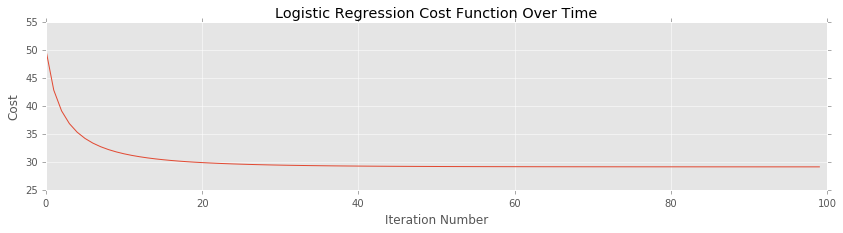

In [15]:
fig, ax = plt.subplots(1, figsize=(14, 3))

plot_cost(gd, ax)

Looks good!

Now that the model has been fit, we can see the estimated coefficients and the final predictions on the training data.

In [16]:
print("Estimated Logistic Coefficients: {}".format(str(gd.coeffs)))
print("Predicted Values on Training Data: {}".format(str(gd.predict(X)[:5])))

Estimated Logistic Coefficients: [ 2.67126918  0.598687  ]
Predicted Values on Training Data: [False False False  True  True]


The coefficients returned from the gradient descent are *not* the `m` and `b` from our earlier eyeball exercise.  Indeed, we have *not* yet included an intercept term in our model, so this coefficient vector really only encodes `m`.

So why two parameters?

Well, the coefficients here encode *two* pieces of information:

  - The slope of the decision boundary.
  - How rapidly the predicted probability changes as we move away from the decision boundary.
  
More precisely, the coefficient vector is *orthogonal* to the decision boundary, and it's length encodes the rate of change of the predicted probabilities.

To find the actual equation of the decision boundary, recall its definition:

$$ h(x) = 0.5 $$

The $h$ here is the logistic function that converts the linear part of the model into probabilities:

$$ h(x) = \frac{1}{1 + e^{-x}} $$

Recall that the *inverse* of the logistic function is the log odds:

$$ h^{-1}(p) = \log \left( \frac{p}{1-p} \right) $$

So, applying the inverse on both sides to the decision boundary equation yields:

$$ \beta_0 x_0 + \beta_1 x_1 = \log \left( \frac{0.5}{1 - 0.5} \right) = 0 $$

Or, rearranging, the equation of the decision boundary is:

$$ x_1 = - \frac{\beta_0}{\beta_1} x_0 $$

Let's plot the fit decision boundary along with our eyeballed attempt.

In [16]:
def plot_decision_bdry_no_intercept(X, gd, ax):
    """Plot the decision boundary from a logistic regression that does 
    not contain an intercept term.
    """
    x0_bounds, x1_bounds = compute_scatterplot_bounds(X)
    t = np.linspace(x0_bounds[0], x0_bounds[1], num=3)
    m = -gd.coeffs[0] / gd.coeffs[1]
    ax.plot(t, m*t, label="Logistic Regression Line")

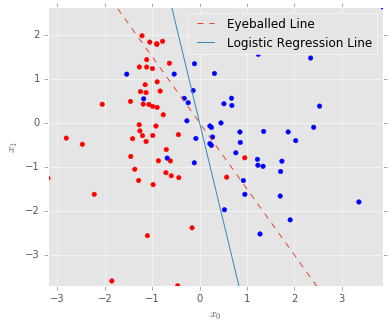

In [17]:
fig, ax = plt.subplots(1, figsize=(6, 5))

plot_classification_data(X, y, ax)
plot_eyeballed_line_no_intercept(X, ax)
plot_decision_bdry_no_intercept(X, gd, ax)
ax.legend()

Notice that *both* lines go through $(0, 0)$, as they should.  Our eyeballed line is clearly worse than the decision boundary returned from logistic regression, as it *must* be (or at least, we should be able to do *no better* than logistic regression).

As a last test, we can fit `sklearn`'s `LogisticRegression` to the same data, and check that we get the same parameter estimates.  A couple things to note here:
  
  - The `LogisticRegression` model from `sklearn` includes regularization.  We set the `C` parameter very large to turn it off.
  - It also includes an intercept by default, there is an option to turn this off.

In [18]:
lr = LogisticRegression(C=10**6, fit_intercept=False)
lr.fit(X, y)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [19]:
print("Gradient Descent Coefficients: {}".format(gd.coeffs))
print("LogisticRegression Coefficents: {}".format(lr.coef_))

Gradient Descent Coefficients: [ 2.67126918  0.598687  ]
LogisticRegression Coefficents: [[ 2.70635687  0.61461823]]


**Note:** The algorithms used in these two approaches are *not the same*.  We use gradient descent, but sklearn uses a linear algebra library intended for fittign support vector machines.

## Add Intercept

We chose to add the function `add_intercept` as a private method in `GradientDescent`.  Private methods have names beginning with an underscore, and are meant to only be used by the class itself, not someone calling methods on the class.

We also added a boolean parameter `fit_intercept` to `GradientDescent.__init__`.  The `GradientDescent` object will automatically add an intercept column to the $X$ matrix before fitting the model when this argument is passed as `True`.

In [20]:
gd_intercept = GradientDescent(lrf.cost, lrf.gradient, lrf.predict, 
                               fit_intercept=True, num_iterations=100)
gd_intercept.fit(X, y)

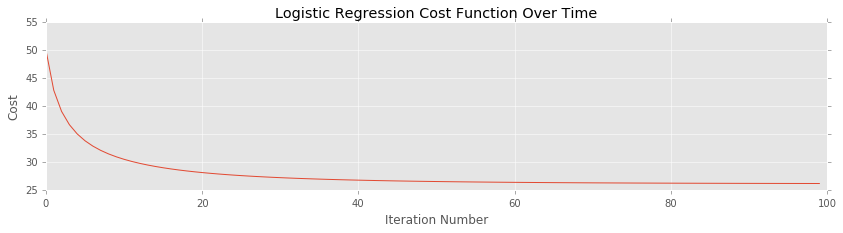

In [21]:
fig, ax = plt.subplots(1, figsize=(14, 3))

plot_cost(gd_intercept, ax)

In [22]:
print("Estimated Logistic Coefficients: {}".format(str(gd_intercept.coeffs)))
print("Predicted Values on Training Data: {}".format(str(gd_intercept.predict(X)[:5])))

Estimated Logistic Coefficients: [ 0.88456661  3.13290089  0.64176149]
Predicted Values on Training Data: [False False False  True  True]


Notice that now we have *three* parameter estimates, the first is the intercept term.

We must go through the arithmetic again to derive the form of the decision boundary, but this time I will spare the details.  The correct expression is:

$$ x_2 = - \frac{\beta_0}{\beta_2} - \frac{\beta_1}{\beta_2} x_1 $$

In [23]:
def plot_decision_bdry(X, gd, ax, extra_label=''):
    """Plot the decision boundary from a logistic regression that
    includes an intercept as the first parameter.
    """
    x0_bounds, x1_bounds = compute_scatterplot_bounds(X)
    t = np.linspace(x0_bounds[0], x0_bounds[1], num=3)
    m = -gd.coeffs[1] / gd.coeffs[2]
    b = -gd.coeffs[0] / gd.coeffs[2]
    ax.plot(t, m*t + b, label="Logistic Regression Line {}".format(extra_label))
    set_scatterplot_bounds(x0_bounds, x1_bounds, ax)

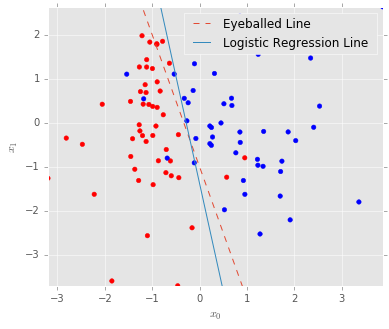

In [24]:
fig, ax = plt.subplots(1, figsize=(6, 5))

plot_classification_data(X, y, ax)
plot_eyeballed_line(X, ax)
plot_decision_bdry(X, gd_intercept, ax)
ax.legend()

We actually did pretty good here with our straightedge and eyeball method!  Even so, a close examination does show the logistic regression line to be superior.

## Scaling / Standardization

We implemented two new methods in `GradientDescent`, `standardize_data_fit` and `standardize_data_transform`.  We do need **two** methods to prevent data leakage: we must fit the standardizer on our training data, and then reuse the parameters from the training data to standardize and test data.

Luckily, `sklearn` already includes a `StandardScaler` class just for this purpose, our implementation simply composes this with our `GradientDescent` class.

Let's fit to our simulated data.

In [25]:
gd_standardized = GradientDescent(lrf.cost, lrf.gradient, lrf.predict, 
                                  fit_intercept=True, standardize=True,
                                  num_iterations=100)
gd_standardized.fit(X, y)

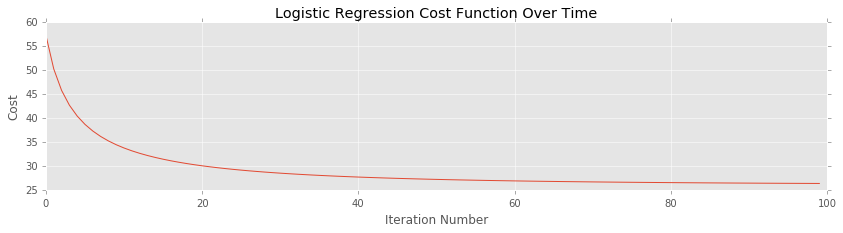

In [26]:
fig, ax = plt.subplots(1, figsize=(14, 3))

plot_cost(gd_standardized, ax)

In [27]:
print("Estimated Logistic Coefficients: {}".format(str(gd_standardized.coeffs)))
print("Predicted Values on Training Data: {}".format(str(gd_standardized.predict(X)[:5])))

Estimated Logistic Coefficients: [ 0.48807566  3.87002467  0.73273223]
Predicted Values on Training Data: [False False False  True  True]


The estimated coefficients are different now, but we should expect that.  These are the estimated coefficients associated with the *standardized* features.

On the other hand, we *should* expect that the predicted values are the same as before:

In [29]:
np.all(gd_standardized.predict(X) == gd_intercept.predict(X))

True

Yay!

## Regularization

The only real trick here is calculating the gradient of the ridge penalty term, but that's really not too difficult

$$ \nabla \left( \lambda \sum_{j=1}^p \beta_j^2 \right) = (0, 2 \lambda \beta_1, \ldots, 2 \lambda \beta_p ) $$

Notice the zero, this is because we *do not penalize the intercept*.  Logistic models have the pleasing property that the sum of the predicted probabilities (on the training data) is the sum of the true response

$$ \sum_i p_i = \sum_i y_i $$

This property would be lost if we regularized the intercept.

From a programming perspective, there are a few points to discuss.

We want to pass through the `lam` parameter *without* breaking the code that we have already written.  There are a few ways to do this, and we have opted for a common simple solution.  We've added an extra parameter to the `__init__` method of `GradientDescent` where we can pass a dictionary to parameters that are to be *passed through* to the `cost` and `gradient` functions.  In the present case, we will use it like

```
..., cost_func_parameters={'lam': 5}, ...
```

One very important python idiom arizes here.  Inside of `fit` our call to `cost` has been modified to look like this:

```
cost = self.cost(X, y, self.coeffs,
                 ...,
                 **self.cost_func_parameters)
```

The `**` in the function call is an extremely useful pythonism, it *unpacks* a dictionary and passes the key, value pairs as keyword arguments to the function being called.  Here, we are using it to unpack the `lam` argument from the dictionary, and pass it into the `cost` function.

Dodging the regularization on the intercept is a challenge.  We could just assume all our models have intercepts, but this would break the code that we wrote earlier in the sprint.  We chose to add a parameter `has_intercept` to both the `cost` and `gradient` functions to handle switching between these two cases.

Let's test this out by adding some simple ridge shrinkage to our test model.

In [28]:
gd_regularized = GradientDescent(lrf.cost, lrf.gradient, lrf.predict, 
                                 fit_intercept=True, standardize=True,
                                 num_iterations=100,
                                 cost_func_parameters={'lam': 5})
gd_regularized.fit(X, y)

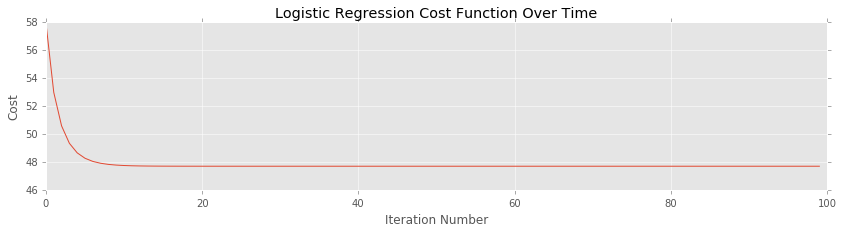

In [29]:
fig, ax = plt.subplots(1, figsize=(14, 3))

plot_cost(gd_regularized, ax)

Now the cost function contains a regularization term, so you can see that the asymptotic cost is *larger* than it was withrout the regularization.

In [30]:
print("Estimated Logistic Coefficients, No Regularization: {}".format(
        str(gd_standardized.coeffs)))
print("Estimated Logistic Coefficients, With Regularization: {}".format(
        str(gd_regularized.coeffs)))

Estimated Logistic Coefficients, No Regularization: [ 0.48807566  3.87002467  0.73273223]
Estimated Logistic Coefficients, With Regularization: [ 0.05517069  1.27515353  0.14784611]


The estimated coefficients have, of course, changed.

We can plot the two decision boundaries, but since we have standardized coefficients, it takes a little bit of extra work.  We choose to simply plot the two decision boundaries against the standardized data.

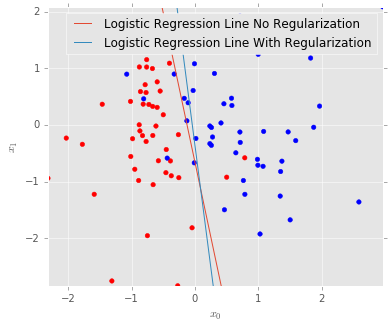

In [33]:
X_std = gd_standardized.standardizer.transform(X)

fig, ax = plt.subplots(1, figsize=(6, 5))

plot_classification_data(X_std, y, ax)
plot_decision_bdry(X_std, gd_standardized, ax, "No Regularization")
plot_decision_bdry(X_std, gd_regularized, ax, "With Regularization")
ax.legend()

It's fun to see what happens to our regularized decision boundary as we vary the parameter:

In [34]:
lambdas = [0.0, 0.5, 1, 2, 5, 10, 25, 50]
models = OrderedDict()

for lam in lambdas:
    gd = GradientDescent(lrf.cost, lrf.gradient, lrf.predict,
                         fit_intercept=True, standardize=True,
                         num_iterations=100,
                         cost_func_parameters={'lam': lam})
    gd.fit(X, y)
    models[lam] = gd

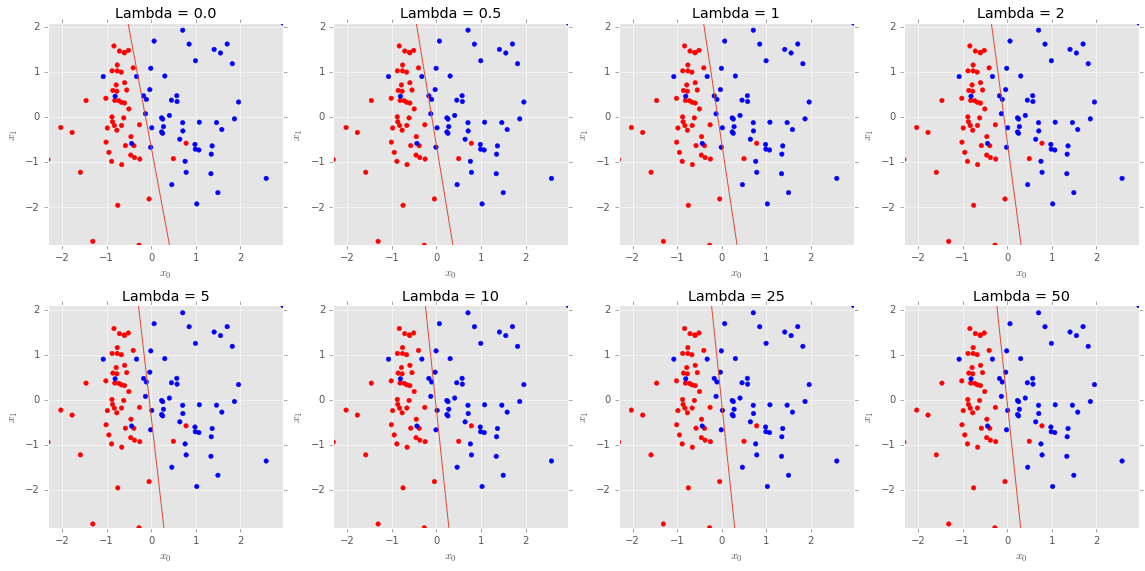

In [35]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for (lam, model), ax in zip(models.iteritems(), axs.flatten()):
    plot_classification_data(X_std, y, ax)
    plot_decision_bdry(X_std, model, ax)
    ax.set_title("Lambda = {}".format(lam))
    
fig.tight_layout()

It looks like the line gets more and more vertical as we increase the regularization parameter.  This isn't a general phenomina.  In fact, as the gets stronger, the decision boundary starts to loose meaning.

It's easier to understand what's going on from the coefficients themselves:

In [36]:
for lam, model in models.iteritems():
    print "Coefficient Estimates for lambda = {}: {}".format(lam, model.coeffs)

Coefficient Estimates for lambda = 0.0: [ 0.48807566  3.87002467  0.73273223]
Coefficient Estimates for lambda = 0.5: [ 0.3042118   2.88309999  0.48213598]
Coefficient Estimates for lambda = 1: [ 0.21483561  2.38859154  0.36487356]
Coefficient Estimates for lambda = 2: [ 0.13211674  1.88012622  0.25532961]
Coefficient Estimates for lambda = 5: [ 0.05517069  1.27515353  0.14784611]
Coefficient Estimates for lambda = 10: [ 0.02281832  0.89194202  0.09556194]
Coefficient Estimates for lambda = 25: [ 0.004808    0.50006046  0.05272964]
Coefficient Estimates for lambda = 50: [ 0.00106653  0.29562066  0.03208536]


Notice how all the coefficients are shrunk towards zero:
  - The two non-intercept coefficients are shrunk by the ridge regression penalty.
  - The intercept term is shrunk towards zero only because we have an equal number of positive and negative cases.  In general, as the other coefficients are shrunk towards zero, the intercept will shrink towards the value that correctly predicts the proportion of positive classes.

In general, the limiting behavior of the decision boundary as the regularization parameter gets larger is not predictable.  What *does* happen is the predicted probabilities become more and more *constant*.

## Termination

We chose to implement the test for convergence in a new method `has_converged` which keeps some clutter out of the already busy fit function.

Inside of fit, we add a check for convergence inside our for loop:

```
if i >= 2 and self.has_converged(cost, self.cost_history[-2]):
    break
```

We need to keep the loop over `num_iterations` in case the convergence criteria is *never* satisfied.  This is a common problem when your implementation of either `cost` or `gradient` has a bug (which could be in either your code or your math).

In [36]:
gd_intercept = GradientDescent(lrf.cost, lrf.gradient, lrf.predict, 
                               fit_intercept=True, num_iterations=100,
                               step_size=0.01)
gd_intercept.fit(X, y)

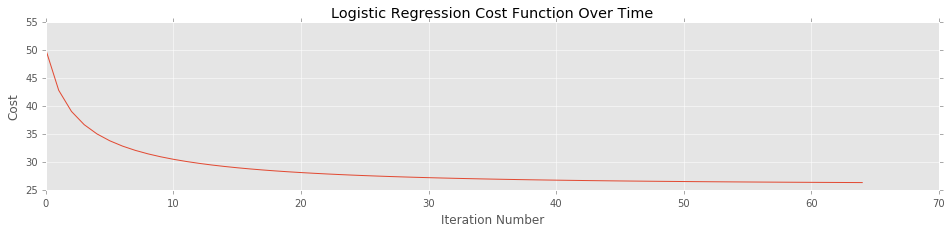

In [37]:
fig, ax = plt.subplots(1, figsize=(16, 3))

plot_cost(gd_intercept, ax)

It looks like it worked!

## Stochastic Gradient Descent

Fitting this implementation into our existing code is a small challenge.  We decided to make the following changes:
  - In `logistic_regression_functions` we have implemented two new functions `cost_one_datapoint` and `gradient_one_datapoint`.  While our earlier versions computed the cost and gradient *across the entire dataset*, these versions implemnt the computation on only a single data point.
  - In the `GradientDescent` class we have implemented a `fit_stochastic` method, which uses the `one_datapoint` versions of cost and gradient, and implements stochastic gradient descent.
  
An additional challenge is identifying an appropriate convergence criteria for stochastic gradient descent.  It does *not* make sense for us to monitor the cost on single data points, as that will be highly variable as we pass through the data.  Instead, we have opted to monitor the cost only after a *full* pass through the data (an epoch), and then observe whether the average cost decreased from the previous epoch.

Below, we've plotted both the loss per data point and the moving average over the last epoch, and you can easily discern the patterns mentioned above:

/Users/matthew.drury/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()


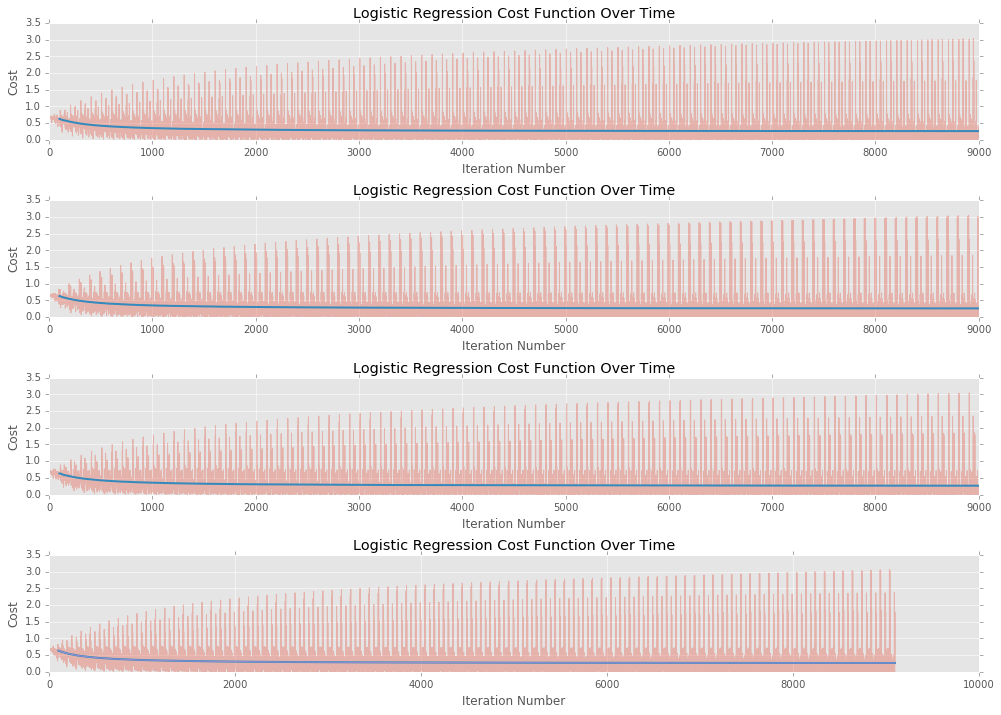

In [38]:
import pandas as pd
fig, axs = plt.subplots(4, figsize=(14, 10))

for ax in axs.flatten():
    gd = GradientDescent(lrf.cost_one_datapoint, lrf.gradient_one_datapoint, lrf.predict, 
                         fit_intercept=True, standardize=True,
                         num_iterations=10000,
                         step_size=0.01, alpha=0.01)

    gd.fit_stochastic(X, y)
    plot_cost(gd, ax, alpha=0.33)
    ch = pd.rolling_mean(pd.Series(gd.cost_history), window=X.shape[0])
    ax.plot(ch.index, ch, linewidth=2)
    
ax.plot(ch.index, ch)
fig.tight_layout()

Let's quickly make sure we are converging to the same place as in regular gradient descent.

In [39]:
gd = GradientDescent(lrf.cost, lrf.gradient, lrf.predict, 
                     fit_intercept=True, standardize=True,
                     num_iterations=10000,
                     step_size=0.01, alpha=0.01)

gd_stochastic = GradientDescent(lrf.cost_one_datapoint, lrf.gradient_one_datapoint, lrf.predict, 
                                fit_intercept=True, standardize=True,
                                num_iterations=10000,
                                step_size=0.01, alpha=0.01)
                                
gd.fit(X, y)
gd_stochastic.fit_stochastic(X, y)
                                
print("Regular Gradient Descent Coefficients: {}".format(gd.coeffs))
print("Stochastic Gradient Descent Coefficients: {}".format(gd.coeffs))

Regular Gradient Descent Coefficients: [ 0.4652795   3.7768793   0.70714281]
Stochastic Gradient Descent Coefficients: [ 0.4652795   3.7768793   0.70714281]


We can also use some ipython magic to time the two fit methods.

In [40]:
%%timeit -n 20
gd.fit(X, y)

20 loops, best of 3: 5.21 ms per loop


In [41]:
%%timeit -n 20
gd_stochastic.fit_stochastic(X, y)

20 loops, best of 3: 265 ms per loop


Clearly the standard gradient descent is smashing out stochastic descent here.  

**This has almost nothing to do with the algorithms themselves.**

In out gradient descent implementation we were able to use very optimized numpy calls to express the entire algorithm, we operated on numpy arrays in their entirety in every computation.  On the other hand, in the stochastic descent implementation, we had to pull rows out of two dimensional arrays, and numbers out of one dimensional arrays.  For reasons that would take us quite far afield, this is almost always *the wrong thing to do* and is extremely pricey.

Unfortunately, numpy does not allow an efficient implementation of stochastic descent, for that we would need to write either C or cython code to manipulate the arrays entry by entry.

If you'd like more insight into exactly what is going on under the hood here, check out this blog post on python internals:

[Why Python is Slow](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/)

and how numpy bypasses this inefficiency:

[Why Numpy Arrays Over Python Lists](http://stackoverflow.com/questions/993984/why-numpy-instead-of-python-lists)

## Newton's Method

**Q**: Using Newton's Method for optimization, write a function that returns one of the local minimas of the quartic function $f(x) = x^4 + 2x^3 - 5x^2 - 8$.

As stated in the description, to use Newton's method we conceptualize the problem finding zeros of the *derivative*.  This requires us competing the derivative and the second derivative.

$$ f'(x) = 4x^3 + 6x^2 - 10x $$
$$ f''(x) = 12x^2 + 12x - 10 $$

In [43]:
def f(x):
    return x**4 + 2 * x**3 - 5 * x**2 - 8
    
def df(x):
    return 4 * x**3 + 6 * x**2 - 10 * x
    
def ddf(x):
    return 12 * x**2 + 12 * x - 10
    
F = [f, df, ddf]
F_names = ["$f$", "$f'$", "$f''$"]

In [ ]:
fig, axs = plt.subplots(3, figsize=(14, 8))

x = np.linspace(-4, 2, num=200)
for i, (ax, function) in enumerate(zip(axs, F)):
    ax.plot(x, function(x), linewidth=3)
    ax.set_title(F_names[i])
    
fig.tight_layout()

We can easily see from the form of the derivative that $x=0$ is a local minima.  The plots show that the other minima may be *near* $x=-2.5$ and $x=1$.  To use Newton's method, we need a place to *start*, and we will use this information to initialize the search at nearby points.

In [45]:
def newtons_method_one_dim(f, df, x0, tol=0.01, max_iter=100):
    """Approximate a zero of the one dimensional function f 
    using Newton's method.
    """
    x_current = x0
    f_current = f(x_current)
    df_current = df(x_current)
    for i in xrange(max_iter):
        if abs(f_current) <= tol:
            return x_current, f_current
        x_current = x_current - (f_current/df_current)
        f_current = f(x_current)
        df_current = df(x_current)
    print("Max iterations reached.  Returning current position.")
    return x_current, f_current

First, let's find the local minimum at at approximately $x=-2.5$.  To do so, it looks like initializing the search at $x_0 = -3$ should work.

In [46]:
newtons_method_one_dim(df, ddf, -3.0)

(-2.5000416396438663, -0.0014574291482496449)

Looks like we guessed correctly!

To find the other minimum, let's initialize at $x_0 = 2$.

In [47]:
newtons_method_one_dim(df, ddf, 2.0)

(1.0002744479215597, 0.003843626774433062)

Again, we were right on.